In [1]:
import openmc.lib # we run simulations using this
import os
import openmc
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import openmc.mgxs as mgxs
import seaborn as sns
%matplotlib inline
from matplotlib.colors import LogNorm

### Variance Reduction - Weight Windows

Simulates the Kobayashi Dog Leg Void Geometry. Uses the MAGIC Method of Weight Windows (WW) generation on each sim run and multi-group cross sections (MGXS) for the implementation of cases with 50% scattering only (Problem 3, 3aii-cii)

### Constructing Single Group Object:

In [2]:
#Make a 1-group object

#the energy group boundaries in eV
groups = mgxs.EnergyGroups(group_edges = np.array([0., 20.0e6]))

# for my universe cell
plane1 = openmc.XPlane(x0= -0.0, boundary_type= 'reflective')
plane2 = openmc.XPlane(x0= +60, boundary_type= 'vacuum')
plane3 = openmc.YPlane(y0= -0.0, boundary_type= 'reflective')
plane4 = openmc.YPlane(y0= +100, boundary_type= 'vacuum')
plane5 = openmc.ZPlane(z0= -0.0, boundary_type= 'reflective')
plane6 = openmc.ZPlane(z0= +60, boundary_type= 'vacuum')


box3 = +plane1 & -plane2 & +plane3 & -plane4 & +plane5 & -plane6

Ucell = openmc.Cell(
                    name='base universe',
                    region = box3)

# domain: the domain for spatial homogenization aka
# averaging the cross sections over volume and flux spectrum

total = mgxs.TotalXS(domain=Ucell, energy_groups=groups)
absorption = mgxs.AbsorptionXS(domain=Ucell, energy_groups=groups)
scattering = mgxs.ScatterXS(domain=Ucell, energy_groups=groups)

### Constructing Cross Section Values:

Changing `True` to `False` will switch the cross-section values to represent Problem II.

In [3]:
# Instantiate the energy group data: energy group boundaries
# sigma_t is the total interaction rate
# sigma_a is absorption cross section
# sigma_s is scattering cross section

ebins = [1e-5, 20.0e6]
groups = openmc.mgxs.EnergyGroups(group_edges=ebins)


Problem_I = False # false = 50% scattering, true = no scattering (pure absorption)

void_sigma_a = 1.0e-4 # assumed not to be 0 so MC can run
void_sigma_s = 0.5e-4
if Problem_I:
    void_sigma_s = 0

void_mat_data = openmc.XSdata('void', groups)
void_mat_data.order = 0
void_mat_data.set_total([void_sigma_a + void_sigma_s])
void_mat_data.set_absorption([void_sigma_a])
void_mat_data.set_scatter_matrix(
    np.rollaxis(np.array([[[void_sigma_s]]]), 0, 3))

absorber_sigma_a = 0.05
absorber_sigma_s = 0.05
if Problem_I:
    absorber_sigma_a = 0.1
    absorber_sigma_s = 0.0

absorber_mat_data = openmc.XSdata('absorber', groups)
absorber_mat_data.order = 0
absorber_mat_data.set_total([absorber_sigma_a + absorber_sigma_s])
absorber_mat_data.set_absorption([absorber_sigma_a])
absorber_mat_data.set_scatter_matrix(
    np.rollaxis(np.array([[[absorber_sigma_s]]]), 0, 3))

source_sigma_a = 0.05
source_sigma_s = 0.05
if Problem_I:
    source_sigma_a = 0.1
    source_sigma_s = 0.0

source_mat_data = openmc.XSdata('source', groups)
source_mat_data.order = 0
source_mat_data.set_total([source_sigma_a + source_sigma_s])
source_mat_data.set_absorption([source_sigma_a])
source_mat_data.set_scatter_matrix(
    np.rollaxis(np.array([[[source_sigma_s]]]), 0, 3))

#Output the cross-sections we just created to a hdf5 file, which we 
# will later tell OpenMC to load
mg_cross_sections_file = openmc.MGXSLibrary(groups)
mg_cross_sections_file.add_xsdatas(
    [source_mat_data, void_mat_data, absorber_mat_data])
mg_cross_sections_file.export_to_hdf5("mgxs.h5")

#### Material for the absorber, source, void:

In [4]:
# Instantiate some Macroscopic Data
source_data = openmc.Macroscopic('source')
void_data = openmc.Macroscopic('void')
absorber_data = openmc.Macroscopic('absorber')

Source = openmc.Material(name='source_mat')
Source.set_density('macro', 1.0)
Source.add_macroscopic('source')

Absorber = openmc.Material(name='absorber_mat')
Absorber.set_density('macro', 1.0)
Absorber.add_macroscopic('absorber')

Void = openmc.Material(name='void_mat')
Void.set_density('macro', 1.0)
Void.add_macroscopic('void')

# Instantiate a Materials collection and export to XML
materials = openmc.Materials([Source,Absorber,Void])
materials.cross_sections = "mgxs.h5"
materials.export_to_xml()

#### Define the geometry:

In [5]:
# Produce the void dog leg regions:

#Void Segment 1:

# plane1 = openmc.XPlane(x0= -0, boundary_type= 'reflective')
plane7 = openmc.XPlane(x0= +10, boundary_type= 'transmission')
plane12 = openmc.YPlane(y0= +10, boundary_type= 'transmission')
plane8 = openmc.YPlane(y0= +60, boundary_type= 'transmission')
# plane5 = openmc.ZPlane(z0= -0, boundary_type= 'reflective')
plane9 = openmc.ZPlane(z0= +10, boundary_type= 'transmission')

segment1 = +plane1 & -plane7 & +plane12 & -plane8 & +plane5 & -plane9 #(0,10,10,60,0,10)


#Void Segment 2:

# plane7 = openmc.XPlane(x0= +10, boundary_type= 'transmission')
plane10 = openmc.XPlane(x0= +40, boundary_type= 'transmission')
plane11 = openmc.YPlane(y0= +50, boundary_type= 'transmission')
# plane8 = openmc.YPlane(y0= +60, boundary_type= 'transmission')
# plane5 = openmc.ZPlane(z0= -0, boundary_type= 'reflective')
# plane9 = openmc.ZPlane(z0= +10, boundary_type= 'transmission')

segment2 = +plane7 & -plane10 & +plane11 & -plane8 & +plane5 & -plane9 #(10,40,50,60,0,10)


#Void Segment 3:
segment3 = openmc.model.RectangularParallelepiped(30,40,50,60,10,40) # can keep parallelpiped since all transmission boundaries

#Void Segment 4:
segment4 = openmc.model.RectangularParallelepiped(30,40,60,99.999,30,40) # can keep parallelpiped since all transmission boundaries

#for my source cell:

# plane1 = openmc.XPlane(x0= -0, boundary_type= 'reflective')
# plane7 = openmc.XPlane(x0= +10, boundary_type= 'transmission')
# plane3 = openmc.YPlane(y0= -0, boundary_type= 'reflective')
#plane12 = openmc.YPlane(y0= +10, boundary_type= 'transmission')
# plane5 = openmc.ZPlane(z0= -0, boundary_type= 'reflective')
# plane9 = openmc.ZPlane(z0= +10, boundary_type= 'transmission')

box2 = +plane1 & -plane7 & +plane3 & -plane12 & +plane5 & -plane9 #(0,10,0,10,0,10)

# for my absorber cell: We want this to match the universe volume in terms of b.c and the size of our geometry

# plane1 = openmc.XPlane(x0= -0.0, boundary_type= 'reflective')
# plane2 = openmc.XPlane(x0= +60, boundary_type= 'vacuum')
# plane3 = openmc.YPlane(y0= -0.0, boundary_type= 'reflective')
# plane4 = openmc.YPlane(y0= +100, boundary_type= 'vacuum')
# plane5 = openmc.ZPlane(z0= -0.0, boundary_type= 'reflective')
# plane6 = openmc.ZPlane(z0= +60, boundary_type= 'vacuum')

box0 = +plane1 & -plane2 & +plane3 & -plane4 & +plane5 & -plane6

#### Cont building geometry & cells:

In [6]:
source_cell = openmc.Cell(fill = Source,
                          region = box2,
                          name = 'source region')

void_cell = openmc.Cell(fill = Void,
                        region = (segment1 | segment2 | -segment3 | -segment4),
                        name = 'void region')

#previously having box0 | ~(segment1 | segment2 | -segment3 | -segment4) caused overlap
absorber_cell = openmc.Cell(fill = Absorber,
                            region = box0 & ~void_cell.region & ~source_cell.region,
                            name = 'absorber region')

# Instantiate a Cell
# Ucell = openmc.Cell(name='base universe',
#                     region = -box3)

# Fill the Cell with the Material
Ucell.fill = Void

# Create root universe
root_universe = openmc.Universe(name='root universe', cells=[source_cell, void_cell, absorber_cell]) #pulled Ucell out of the root universe

# Create Geometry and set root Universe
openmc_geometry = openmc.Geometry(root_universe)
openmc_geometry.merge_surfaces=True

# Export to "geometry.xml"
openmc_geometry.export_to_xml()

#### Mesh & Filter Object for the tallies in Kobayashi Report Table 4:

In [7]:
a_mesh = openmc.RegularMesh()
a_mesh.dimension = [1,92,1] # number of bins
a_mesh.lower_left = [4.5, 4.5, 4.5] # physical "corners" of mesh
a_mesh.upper_right =[5.5, 95.5, 5.5]


b_mesh = openmc.RegularMesh()
b_mesh.dimension = [52,1,1]
b_mesh.lower_left = [4.5 , 54.5 , 4.5]
b_mesh.upper_right =[55.5, 55.5, 5.5]

c_mesh = openmc.RegularMesh()
c_mesh.dimension = [52,1,1]
c_mesh.lower_left = [4.5, 94.5, 34.5]
c_mesh.upper_right =[55.5, 95.5 , 35.5]

a_mesh_filter = openmc.MeshFilter(a_mesh)

b_mesh_filter = openmc.MeshFilter(b_mesh) 

c_mesh_filter = openmc.MeshFilter(c_mesh)

#### Mesh and Filter Object for my Geometry:

In [8]:
geo_mesh = openmc.RegularMesh()
geo_mesh.dimension = [60,100,60]
geo_mesh.lower_left = [0,0,0]
geo_mesh.upper_right =[60,100,60]

geo_mesh_filter = openmc.MeshFilter(geo_mesh)

#### Tallies object for my tallies in Table 4:

In [9]:
a_tally = openmc.Tally(name = '3A Flux Tally')
a_tally.filters = [a_mesh_filter] 
a_tally.scores = ['flux']


b_tally = openmc.Tally(name = '3B Flux Tally')
b_tally.filters = [b_mesh_filter]
b_tally.scores = ['flux'] 


c_tally = openmc.Tally(name = '3C Flux Tally')
c_tally.filters = [c_mesh_filter]
c_tally.scores = ['flux']

#### Tallies object for my Weight Windows:

In [10]:
flux_tally = openmc.Tally(name= 'Flux Tally')
flux_tally.filters = [geo_mesh_filter]
flux_tally.scores = ["flux"]

# Set ID number to access during openmc run:
flux_tally.id = 4

/home/vagrant/.pyenv/versions/py3/lib/python3.9/site-packages/openmc/mixin.py:70: IDWarning: Another Tally instance already exists with id=4.
  warn(msg, IDWarning)


In [11]:
# Export to "tallies.xml"
tallies = openmc.Tallies([a_tally, b_tally, c_tally, flux_tally])
tallies.export_to_xml()

### Settings, and changing Number of Neutrons & Batches:

In [12]:
# Instantiate a Settings object, set all runtime parameters, and export to XML
settings = openmc.Settings()
settings.energy_mode = "multi-group"
settings.batches = 10
settings.particles = 1_000_000
settings.run_mode = 'fixed source'

# Create an initial uniform spatial source distribution over fissionable zones
bounds = [0,0,0,10,10,10] # match the geometry bounds for my source [xmin,ymin,zmin,xmax,ymax,zmax]
uniform_dist = openmc.stats.Box(bounds[:3], bounds[3:])
energy_mono = openmc.stats.Discrete([1.0], [1.0]) # specifying a monenergentic point source, 1eV for 100% of particles
settings.source = openmc.IndependentSource(energy = energy_mono, space = uniform_dist)

# Export to "settings.xml"
settings.export_to_xml()

#### Function to create the flux plot, std, weight window upper bound:

In [13]:
def plot_mesh_tally_and_weight_window(statepoint_filename, weight_window_filename, image_filename):
    
    with openmc.StatePoint(statepoint_filename) as sp:
        flux_tally = sp.get_tally(name= 'Flux Tally')

    tally_mesh = flux_tally.find_filter(openmc.MeshFilter).mesh
    tally_mesh_extent = geo_mesh.bounding_box.extent['xy']

    # get a slice of mean values on the xy basis z=0 axis
    flux_mean = flux_tally.get_reshaped_data(value='mean', expand_dims=True).squeeze()[:,:,0] # originating at z = 0
    plt.subplot(2,3,1) # makes a 2x3 plot displayed 1st
    plt.tight_layout()
    # create a plot of the mean flux values
    plt.imshow(
        flux_mean.T,
        origin="lower",
        extent=tally_mesh_extent,
        norm=LogNorm(),
        aspect='auto',
        interpolation='nearest'
    )
    plt.colorbar()
    plt.title("Flux Mean")
    plt.xlabel('x (cm)')
    plt.ylabel('y (cm)')

    # get a slice of relative error values on the xy basis z = 0 
    flux_std_dev = flux_tally.get_reshaped_data(value='rel_err', expand_dims=True).squeeze()[:,:,0] # originating at z = 0
    plt.subplot(2,3,2) # makes a 2x3 plot displayed 2nd
    plt.tight_layout() # this will fix the overlap on plots
    # create a plot of the flux relative error
    plt.imshow(
        flux_std_dev.T,
        origin="lower",
        extent=tally_mesh_extent,
        aspect='auto',
        interpolation='nearest'
    )
    plt.colorbar()
    plt.title("Flux Rel. Err.")
    plt.xlabel('x (cm)')
    plt.ylabel('y (cm)')
    
    
    wws_=openmc.hdf5_to_wws(weight_window_filename)
    ww = wws_[0]  # get the one and only mesh tally
    ww_mesh = ww.mesh  # get the mesh that the weight window is mapped on
    ww_mesh_extent = ww_mesh.bounding_box.extent['xy']
    # this is calling the upper bound and shaping it to create plot
    reshaped_ww_vals_upper = ww.upper_ww_bounds.reshape(geo_mesh.dimension)
   
    # get a slice on XY basis, at z = 0
    slice_of_ww_upper = reshaped_ww_vals_upper[:,:,0]
    plt.subplot(2,3,3)
    plt.tight_layout()
    # create a plot of the ww upper bounds
    plt.imshow(
        slice_of_ww_upper.T,
        origin="lower",
        extent=ww_mesh_extent,
        norm=LogNorm(),
        aspect='auto',
        interpolation='nearest'
    )
    plt.colorbar()
    plt.title("Weight Window Upper Bound")
    plt.xlabel('x (cm)')
    plt.ylabel('y (cm)')
    
    plt.savefig(image_filename, bbox_inches="tight")

### Use Weight Windows Loop to run number of iterations:
Two possible ways for weight window generation, with slight changes (to compare if perhaps the set up was causing discrepancies)

In [14]:
def gen_ww(tally_id):


    openmc.lib.init([])
    openmc.lib.simulation_init()
    #openmc.lib.settings.particles =  #these particles will eventually split, can turn it off because it would override

    tally = openmc.lib.tallies[tally_id]

    wws = openmc.lib.WeightWindows.from_tally(tally,particle = 'neutron')

    iterations = 10

    n_batches = openmc.lib.settings.get_batches()
    
    for i in range(iterations):
        print("f'Iteration {i}")
        openmc.lib.run() #run the simulation

        os.rename(f'statepoint.{n_batches}.h5', f'statepoint.{n_batches}.{i}.h5')
        print("Updating")
        wws.update_magic(tally, value='rel_err', threshold=1.0) #updates the weight window with the latest tally results
        print("Done updating")

        openmc.lib.settings.weight_windows_on = True #turns on weight windows to ensure they are used
        if i % 2 == 0: #this doubles the amount of particles were iteration
            openmc.lib.settings.particles *= 2
        openmc.lib.reset()

        print("Writing weight windows")
        openmc.lib.export_weight_windows(filename = f'weight_windows{i}.h5') #write out the weight window maps for plotting later

    # creates a plot of the flux, std_dev and weight window
    plot_mesh_tally_and_weight_window(
        f'statepoint.{n_batches}.{i}.h5',
        f'weight_windows{i}.h5',
        f'plot_{i}.png'
        )
    
    openmc.lib.finalize()

Call the Function to run OpenMC with WW:

                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

/home/vagrant/.pyenv/versions/py3/lib/python3.9/site-packages/openmc/tallies.py:1278: RuntimeWarning: invalid value encountered in divide
  data = self.std_dev[indices] / self.mean[indices]
/home/vagrant/.pyenv/versions/py3/lib/python3.9/site-packages/openmc/mixin.py:70: IDWarning: Another MeshBase instance already exists with id=4.
  warn(msg, IDWarning)


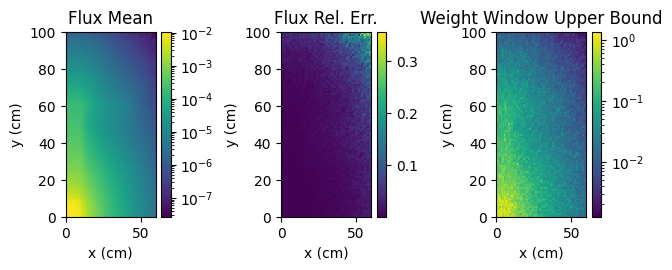

In [15]:
gen_ww(4) #use the tally id

In [16]:
# with openmc.lib.run_in_memory():

#     # loads up a live pointer to the tally with id=4, at this stage the tally is empty
#     tally = openmc.lib.tallies[4]

#     # makes weight windows from the tally, at this stage the values are empty
#     wws = openmc.lib.WeightWindows.from_tally(tally, particle='neutron')

#     iterations = 15
#     n_batches = openmc.lib.settings.get_batches()
    
#     # N iterations of weight window improvements
#     for i in range(iterations):

#         # run the simulation
#         openmc.lib.run()

#         # improves the weight window with the latest tally results
#         wws.update_magic(tally,value='rel_err', threshold=1.0 )

#         # we write out the weight window map for plotting later
#         openmc.lib.export_weight_windows(filename=f'weight_windows{i}.h5')
#         # we write out the statepoint so that the tally can be plotted later
#         os.rename(f'statepoint.{n_batches}.h5', f'statepoint.{n_batches}.{i}.h5')

#         # turns on the weight windows to ensure they are used
#         openmc.lib.settings.weight_windows_on = True

#     # creates a plot of the flux, std_dev and weight window
#     plot_mesh_tally_and_weight_window(
#         f'statepoint.{n_batches}.{i}.h5',
#         f'weight_windows{i}.h5',
#         f'plot_{i}.png'
#         )

Function to run with the latest weight windows file and produce a new statepoint:

In [17]:
def use_ww(i):
    openmc.lib.init([])
    openmc.lib.simulation_init()
    openmc.lib.settings.particles = 2_000_000 # in case 3Cii turn this on so we can run with more particles with the latest WW
    openmc.lib.settings.weight_windows_on = True #turns on weight windows to ensure they are used
    
    n_batches = openmc.lib.settings.get_batches()
    
    
    openmc.lib.import_weight_windows(filename = f'weight_windows{i}.h5', output=True)
    print('Using the final weight window to update:')
    
    openmc.lib.run() #run the simulation
    os.rename(f'statepoint.{n_batches}.h5', f'statepoint.{n_batches}.{i}.ww.h5')
    print("Update Complete")
    
     # creates a plot of the flux, std_dev and weight window by calling the function
    plot_mesh_tally_and_weight_window(
        f'statepoint.{n_batches}.{i}.ww.h5',
        f'weight_windows{i}.h5',
        f'plot_{i}.ww.png'
        )

    openmc.lib.finalize()

                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

/home/vagrant/.pyenv/versions/py3/lib/python3.9/site-packages/openmc/tallies.py:1278: RuntimeWarning: invalid value encountered in divide
  data = self.std_dev[indices] / self.mean[indices]
/home/vagrant/.pyenv/versions/py3/lib/python3.9/site-packages/openmc/mixin.py:70: IDWarning: Another MeshBase instance already exists with id=4.
  warn(msg, IDWarning)
/home/vagrant/.pyenv/versions/py3/lib/python3.9/site-packages/openmc/mixin.py:70: IDWarning: Another WeightWindows instance already exists with id=1.
  warn(msg, IDWarning)


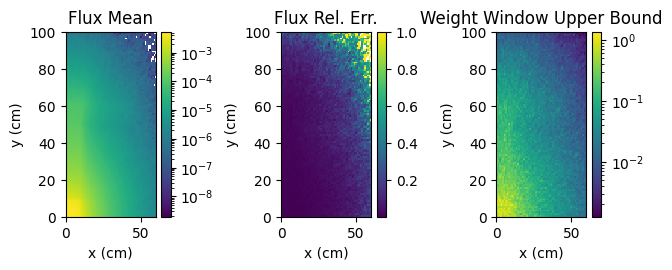

In [18]:
use_ww(9) #call final weight window file

Statepoint files WITH Weight Windows (WW):

In [56]:
sp = openmc.StatePoint('statepoint.10.9.h5')

Extract flux tally for entire geometry:

In [57]:
flux_results = sp.get_tally(name = 'Flux Tally')

Extract the flux score for entire geometry: 

In [58]:
flux = flux_results.get_slice(scores=['flux'])
flux_array = flux.mean

Extract the 3A,3B,3C tallies WITH WW:

In [59]:
A_ww_results = sp.get_tally(name = '3A Flux Tally')
B_ww_results = sp.get_tally(name = '3B Flux Tally')
C_ww_results = sp.get_tally(name = '3C Flux Tally')

Extract the mean flux and std deviation for 3A,3B,3C WITH WW:

Each voxel has a face area of 1cm^2, so that's the unit conversion you need for the number recorded in each voxel. But, you also have to multiply by 1000 because the source volume is 1000cm^3 and the source rate is 1 neutron/cm^3/s

In [60]:
a_flux = A_ww_results
a_flux_array = a_flux.mean * 1000
a_std_array = a_flux.std_dev * 1000


b_flux= B_ww_results
b_flux_array = b_flux.mean * 1000
b_std_array = b_flux.std_dev * 1000

c_flux= C_ww_results
c_flux_array = c_flux.mean * 1000
c_std_array = c_flux.std_dev * 1000

In [61]:
# print(a_std_array)

Statepoint files WITHOUT WW:

In [62]:
sp_no_ww = openmc.StatePoint('statepoint.10.0.h5') 

Extract the 3A,3B,3C tallies WITHOUT WW: 

In [63]:
A_noww_results = sp_no_ww.get_tally(name = '3A Flux Tally')
B_noww_results = sp_no_ww.get_tally(name = '3B Flux Tally')
C_noww_results = sp_no_ww.get_tally(name = '3C Flux Tally')

Extract the mean flux and std deviation for 3A,3B,3C WITHOUT WW:

In [64]:
a_noww_flux= A_noww_results
a_noww_flux_array = a_noww_flux.mean * 1000
a_noww_std_array = a_noww_flux.std_dev * 1000

b_noww_flux= B_noww_results
b_noww_flux_array = b_noww_flux.mean * 1000 
b_noww_std_array = b_noww_flux.std_dev * 1000 

c_noww_flux= C_noww_results
c_noww_flux_array = c_noww_flux.mean * 1000 
c_noww_std_array = c_noww_flux.std_dev * 1000

Relative Error for 3A:

[0.04424056 0.11431356 0.22282305 0.33030255 0.37515822 0.25948537
 0.3334752  0.79116373 1.64017221 3.02713577]
[ 0.27086011  0.61094774  1.20804632  0.68303086  1.31291622  2.1189737
  2.3277959   4.06363802 11.29956972 19.85135547]
[0.04475612 0.11411521 0.22212447 0.3266731  0.37314039 0.25801038
 0.31504215 0.73604494 1.53516888 2.78923166]
[ 98.84806575 100.1738133  100.31449919 101.11103363 100.54076896
 100.57167532 105.85097824 107.48850832 106.83985559 108.52937803]


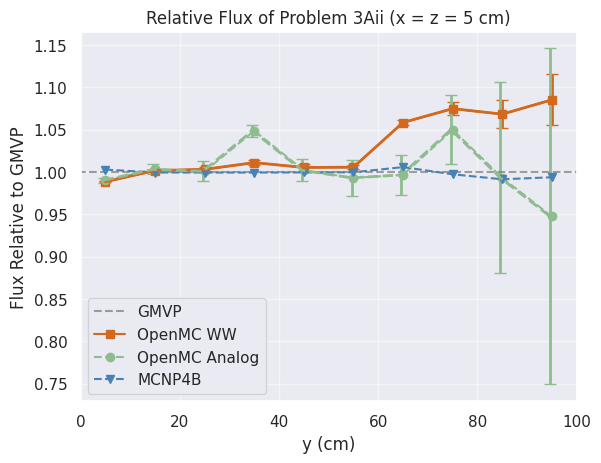

In [84]:
fig, ax = plt.subplots()

# plotting the flux values for gmvp, mcnp, and openmc ww, and openmc analog:
flux_by_gmvp = np.array([8.61578e-0 , 2.16130e-0 , 8.93784e-1, 4.78052e-1,2.89424e-1,1.92698e-1,1.0482e-1,3.37544e-2,
                     1.08158e-2,3.39632e-3])
flux_by_mcnp = np.array([8.6410e-0, 2.1601e-0, 8.9324e-1,4.7776e-1,2.8929e-1, 1.9264e-1, 1.0543e-1, 3.3665e-2,  1.0723e-2,3.3753e-3])
flux_by_openmc = np.squeeze(a_flux_array[0::10])
flux_by_analog = np.squeeze(a_noww_flux_array[0::10])

y_dist = list(range(5, 105, 10))

# relative error between ww and gmvp:
ww_gmvp = flux_by_openmc / flux_by_gmvp

# relative error between analog and gmvp:
analog_gmvp = flux_by_analog / flux_by_gmvp

# the relative error between mcnp and gmvp:
mcnp_rel_err = flux_by_mcnp / flux_by_gmvp

# the uncertainty in the ww:
ww_rel_error = A_ww_results.get_values(value='rel_err')
ww_rel_err = np.squeeze(ww_rel_error[0::10])

# the uncertainty in the analog:
analog_rel_error = A_noww_results.get_values(value='rel_err')
analog_rel_err = np.squeeze(analog_rel_error[0::10])

# plotting the error bars for ww:
ww_uncertainty = abs((ww_rel_err * flux_by_openmc) / (flux_by_gmvp))

ax.errorbar(y_dist,
            ww_gmvp, 
            yerr= ww_uncertainty, 
            linewidth = 2.0,
            capsize = 4.0,
            color = 'chocolate')

# plotting the error bars for Analog:
analog_uncertainty = abs((analog_rel_err * flux_by_analog) / (flux_by_gmvp))

ax.errorbar([x-0.35 for x in y_dist], 
            analog_gmvp, 
            yerr= analog_uncertainty, 
            linewidth = 2.0,
            capsize = 4.0,
            linestyle= '--',
            color = 'darkseagreen')


# Organizing plot:
plt.title('Relative Flux of Problem 3Aii (x = z = 5 cm)')
plt.xlabel('y (cm)')
plt.ylabel('Flux Relative to GMVP')
#plt.ylim(0.5, 1.5)
plt.xlim(0,100)
plt.hlines(1, -.5, 100, 
           color = 'gray',
           linestyle= '--', 
           alpha = 0.75, 
           label= 'GMVP')
plt.plot(y_dist,
         ww_gmvp, 
         '-s',
         label = 'OpenMC WW',
         color = 'chocolate')
plt.plot(y_dist,
         analog_gmvp, 
         '--o',
         label = 'OpenMC Analog',
         color = 'darkseagreen')
plt.plot(y_dist, 
        mcnp_rel_err,
        '--v', 
         label = 'MCNP4B',
        color = 'steelblue')

plt.legend(loc = 'lower left')
plt.grid(True, which="both", alpha=0.5)
sns.set_theme(style="darkgrid")


plt.show

print(ww_uncertainty * 100)
print(analog_uncertainty * 100)

print(ww_rel_err * 100)

print(ww_gmvp * 100)

Relative Error for 3B:

[0.32408067 0.740418   0.94354164 1.15715702 3.48154855 4.78999153]
[ 2.17724505  4.96936978  5.38202544 11.26982933  9.29501975 21.20707425]
[0.33050697 0.72654875 0.93368932 1.14020501 3.18938309 4.42374508]
[ 98.05562408 101.90892249 101.05520273 101.48675104 109.16056357
 108.2791039 ]


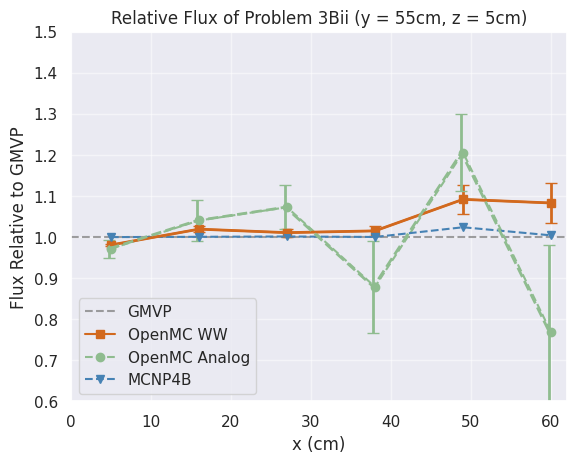

In [82]:
fig, ax = plt.subplots()


#plotting the flux values for gmvp, mcnp, and openmc:
flux_by_gmvp = np.array([1.92698e-1 ,6.72147e-2 , 2.21799e-2, 9.90646e-3, 3.39066e-3, 1.05629e-3])
flux_by_mcnp = np.array([1.9264e-1, 6.7242e-2, 2.2207e-2, 9.9066e-3, 3.4710e-3,1.0605e-3])
flux_by_openmc = np.squeeze(b_flux_array[0::10])
flux_by_analog = np.squeeze(b_noww_flux_array[0::10])

y_dist = np.linspace(5,60,6)

# rel error between openmc and gmvp:
ww_gmvp = flux_by_openmc / flux_by_gmvp

# rel error between analog and gmvp:
analog_gmvp = flux_by_analog / flux_by_gmvp

# the uncertainty in mcnp:
mcnp_rel_err = flux_by_mcnp / flux_by_gmvp

# the uncertainty in the ww:
ww_rel_error = B_ww_results.get_values(value='rel_err')
ww_rel_err = np.squeeze(ww_rel_error[0::10])

ww_uncertainty = abs((ww_rel_err * flux_by_openmc) / (flux_by_gmvp))

# uncertainty in the analog:
analog_rel_error = B_noww_results.get_values(value='rel_err')
analog_rel_err = np.squeeze(analog_rel_error[0::10])

analog_uncertainty = abs((analog_rel_err * flux_by_analog) / (flux_by_gmvp))

# plotting the error bars for ww:
ax.errorbar(y_dist, 
            ww_gmvp, 
            yerr= ww_uncertainty, 
            linewidth = 2.0,
            capsize = 4.0,
           color = 'chocolate')

# plotting the error bars for analog:
analog_uncertainty = abs((analog_rel_err * flux_by_analog) / (flux_by_gmvp))
ax.errorbar([x-0.2 for x in y_dist], 
            analog_gmvp, 
            yerr= analog_uncertainty, 
            linewidth = 2.0,
            capsize = 4.0,
            linestyle = '--',
           color = 'darkseagreen')

# Organizing plot:
plt.title('Relative Flux of Problem 3Bii (y = 55cm, z = 5cm)')
plt.xlabel('x (cm)')
plt.ylabel('Flux Relative to GMVP')
plt.ylim(0.60, 1.5)
plt.xlim(0,62)

plt.hlines(1, 0, 62, 
           color = 'gray',
           linestyle= '--', 
           alpha = 0.75, 
           label= 'GMVP')
plt.plot(y_dist,
         ww_gmvp, 
         '-s',
         label = 'OpenMC WW',
         color = 'chocolate')
plt.plot(y_dist,
         analog_gmvp, 
         '--o',
         label = 'OpenMC Analog',
        color = 'darkseagreen')
plt.plot(y_dist, 
        mcnp_rel_err,
        '--v', 
         label = 'MCNP4B',
         color = 'steelblue')

plt.legend(loc = 'lower left')
plt.grid(True, which="both", alpha=0.5)
sns.set_theme(style="darkgrid")

plt.show

print(ww_uncertainty * 100)
print(analog_uncertainty * 100)

print(ww_rel_err * 100)

print(ww_gmvp* 100)

Relative Error for 3Cii:

[11.49575827 12.98310232 11.9842486   5.73083303 14.19414132 28.80183819]
[ 35.31733658  49.20115431  23.6988186   38.38935486 144.28837793
 250.62274256]


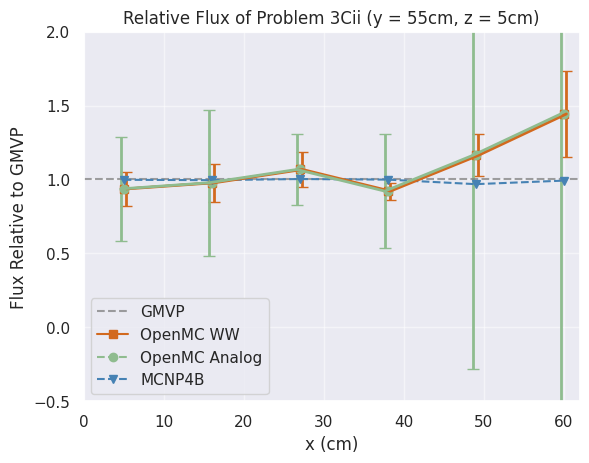

In [85]:
fig, ax = plt.subplots()


#plotting the flux values for gmvp, mcnp, and openmc:
# plotting the flux values for gmvp, mcnp, openmc ww, and analog
flux_by_gmvp = np.array([3.44804e-4 ,2.91825e-4 , 2.05793e-4, 2.62086e-4, 1.05367e-4, 4.44962e-5])
flux_by_mcnp = np.array([3.4411e-4, 2.9050e-4, 2.0643e-4, 2.6187e-4, 1.0205e-4, 4.4155e-5])
flux_by_openmc = np.squeeze(c_flux_array[0::10])
flux_by_analog = np.squeeze(c_noww_flux_array[0::10])

y_dist = np.linspace(5,60,6)


# relative error between ww and gmvp:
ww_gmvp = flux_by_openmc / flux_by_gmvp

# relative error between analog and gmvp:
analog_gmvp = flux_by_openmc / flux_by_gmvp

# the uncertainty in MCNP:
mcnp_rel_err = flux_by_mcnp / flux_by_gmvp

# the uncertainty in the ww and analog values:
ww_rel_error = C_ww_results.get_values(value='rel_err')
ww_rel_err = np.squeeze(ww_rel_error[0::10])

analog_rel_error = C_noww_results.get_values(value='rel_err')
analog_rel_err = np.squeeze(analog_rel_error[0::10])

# plotting the error bars for WW:
ww_uncertainty = abs((ww_rel_err * flux_by_openmc) / (flux_by_gmvp))
ax.errorbar([x+0.35 for x in y_dist], 
            ww_gmvp, 
            yerr = ww_uncertainty, 
            linewidth = 2.0,
            capsize = 4.0,
            color = 'chocolate')

# plotting the error bars for Analog:
analog_uncertainty = abs((analog_rel_err * flux_by_analog) / (flux_by_gmvp))
ax.errorbar([x-0.35 for x in y_dist], 
            analog_gmvp, 
            yerr = analog_uncertainty, 
            linewidth = 2.0,
            capsize = 4.0,
            color = 'darkseagreen')

# Organizing plot:
plt.title('Relative Flux of Problem 3Cii (y = 55cm, z = 5cm)')
plt.xlabel('x (cm)')
plt.ylabel('Flux Relative to GMVP')
plt.ylim(-.5, 2.0)
plt.xlim(0,62)

plt.hlines(1, 0, 62, 
           color = 'gray',
           linestyle= '--', 
           alpha = 0.75, 
           label= 'GMVP')
plt.plot(y_dist,
         ww_gmvp, 
         '-s',
         label = 'OpenMC WW',
        color = 'chocolate')
plt.plot(y_dist,
         analog_gmvp, 
         '--o',
         label = 'OpenMC Analog',
         color = 'darkseagreen')
plt.plot(y_dist, 
        mcnp_rel_err,
        '--v', 
         label = 'MCNP4B',
        color = 'steelblue')

plt.legend(loc = 'lower left')
plt.grid(True, which="both", alpha=0.5)
sns.set_theme(style="darkgrid")

plt.show

print(ww_uncertainty * 100)
print(analog_uncertainty * 100)

### Plotting OpenMC WW vs GMVP:

<Figure size 500x1000 with 0 Axes>

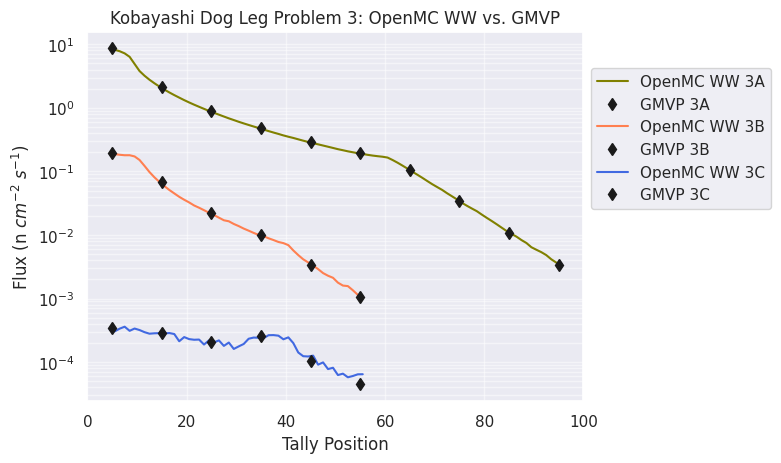

In [68]:
# Plot 3Aii:
plt.figure(figsize=(5,10)) 
fig, ax = plt.subplots()

#plotting 3a W/ WW:
x = np.linspace(4.5,95.5,92)
y = a_flux_array.reshape(92)
a_ww = ax.plot(x,y, label = 'OpenMC WW 3A', color='olive')

# plotting 3a gvmp values:
gmvp_x = np.linspace(5,95,10)
gmvp_y = np.array([8.61578e-0 , 2.16130e-0 , 8.93784e-1, 4.78052e-1,2.89424e-1,1.92698e-1,1.0482e-1,3.37544e-2,
                     1.08158e-2,3.39632e-3])

a_gmvp = ax.plot(gmvp_x, 
               gmvp_y,
               'kd',
               label = 'GMVP 3A')

#Plotting 3b W/ WW:
x = (np.linspace(4.5,55.5,52))
y = b_flux_array.reshape(52)
b_ww = ax.plot(x,y, label = 'OpenMC WW 3B', color='coral')


# plotting 3b gmvp values:
gmvp_x = np.linspace(5,55,6)
gmvp_y = np.array([1.92698e-1 ,6.72147e-2 , 2.21799e-2, 9.90646e-3,3.39066e-3,1.05629e-3])

b_gmvp = ax.plot(gmvp_x, 
               gmvp_y, 
               'kd', 
               label = 'GMVP 3B')

# plotting 3c W/ WW:
x = (np.linspace(4.5,55.5,52))
y = c_flux_array.reshape(52)
c_ww = ax.plot(x,y,label = 'OpenMC WW 3C', color='royalblue')

# plotting 3c gmvp values:
gmvp_x = np.linspace(5,55,6)
gmvp_y = np.array([3.44804e-4 ,2.91825e-4 , 2.05793e-4, 2.62086e-4,1.05367e-4,4.44962e-5])

c_gmvp = ax.plot(gmvp_x, 
               gmvp_y, 
               'kd', 
               label = 'GMVP 3C')

#scaling of plot:
plt.xlim(0,100)
plt.yscale("log")

#formatting of plot
plt.legend(loc='upper right')
plt.xlabel("Tally Position")
plt.ylabel("Flux (n $cm^{-2}$ $s^{-1}$)")
plt.title("Kobayashi Dog Leg Problem 3: OpenMC WW vs. GMVP")
plt.legend(loc='lower left', bbox_to_anchor=(1, 0.5)) #puts the legend to the right side of the plot
plt.grid(True, which="both", alpha=0.5)
sns.set_theme(style="darkgrid")

plt.show()  

### Plotting OpenMC Analog vs OpenMC WW:

<Figure size 500x1000 with 0 Axes>

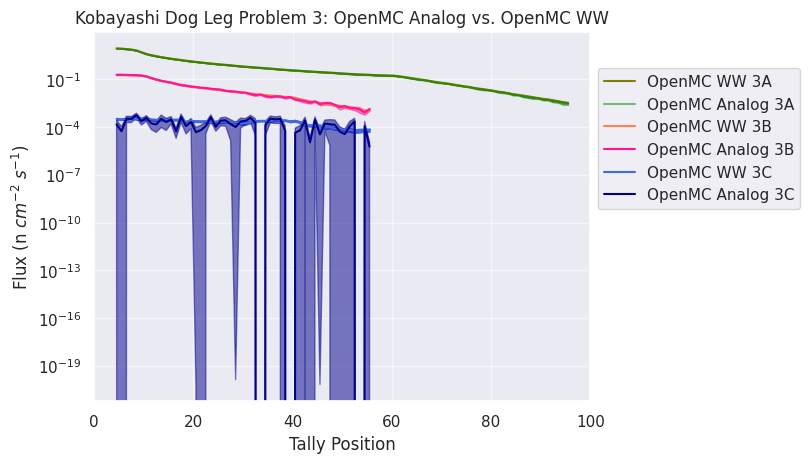

In [69]:
# Plot 3Aii:
plt.figure(figsize=(5,10)) 
fig, ax = plt.subplots()

#plotting 3a W/ WW:
x = np.linspace(4.5,95.5,92)
y = a_flux_array.reshape(92)
a_ww = ax.plot(x,y, label = 'OpenMC WW 3A', color='olive')

#plotting errors
yerr_a = a_std_array.reshape(92)
ax.fill_between(x,y+yerr_a,y-yerr_a, alpha=0.50, color='olive')

#plotting 3a W/O WW FOR ANALOG RUN:
x = np.linspace(4.5,95.5,92)
y = a_noww_flux_array.reshape(92)
a_noww = ax.plot(x,
                 y, 
                 label = 'OpenMC Analog 3A', 
                 color ='green', 
                 alpha = .5)

#plotting errors
yerr_a = a_noww_std_array.reshape(92)
ax.fill_between(x,
                y+yerr_a,
                y-yerr_a, 
                color ='green', 
                alpha =.5)

#Plotting for 3b W/ WW:
x = (np.linspace(4.5,55.5,52))
y = b_flux_array.reshape(52)

b_ww = ax.plot(x,y, label = 'OpenMC WW 3B', color='coral')

#plotting error bars:
yerr_b = b_std_array.reshape(52)
plt.fill_between(x,
                 y+yerr_b,
                 y-yerr_b,color = 'coral', 
                 alpha=0.50)

#Plotting 3b W/O WW for Analog Run:
x = (np.linspace(4.5,55.5,52))
y = b_noww_flux_array.reshape(52)
b_noww = ax.plot(x,
                 y, 
                 label = 'OpenMC Analog 3B', 
                 color = 'deeppink')

#plotting error bars:
yerr_b_noww = b_noww_std_array.reshape(52)
ax.fill_between(x,
                y-yerr_b_noww,
                y+yerr_b_noww,
                color = 'deeppink', 
                alpha=0.50)

#Plotting for 3c W/ WW:
x = (np.linspace(4.5,55.5,52))
y = c_flux_array.reshape(52)
c_ww = ax.plot(x,
               y,
               label = 'OpenMC WW 3C', 
               color='royalblue')

#plotting error bars
yerr_c = c_std_array.reshape(52)
plt.fill_between(x,y+yerr_c,
                 y-yerr_c,
                 color ='royalblue')

#Plotting W/O WW for Analog Run:
x = (np.linspace(4.5,55.5,52))
y = c_noww_flux_array.reshape(52)
c_noww = ax.plot( x,
                 y,
                 label = 'OpenMC Analog 3C', 
                 color = 'darkblue')

yerr_c_noww = c_noww_std_array.reshape(52)
plt.fill_between(x,
                 y-yerr_c_noww,
                 y+yerr_c_noww, 
                 color ='darkblue', 
                 alpha=0.50)


#scaling of plot:
plt.xlim(0,100)
plt.yscale("log")

#formatting of plot
plt.legend(loc='upper right')
plt.xlabel("Tally Position")
plt.ylabel("Flux (n $cm^{-2}$ $s^{-1}$)")
plt.title("Kobayashi Dog Leg Problem 3: OpenMC Analog vs. OpenMC WW")
plt.legend(loc='lower left', bbox_to_anchor=(1, 0.5))
plt.grid(True, which="both", alpha=0.5)
sns.set_theme(style="darkgrid")

plt.show()  

Creating voxel file to create plot.vti to generate in paraview:

In [33]:
# vox = openmc.Plot()
# vox.type = 'voxel'
# vox.width = (60 ,100, 60)
# vox.pixels = (400,400,400)
# vox.origin = (30,50,30) # make sure the origin is at the center of your shape
# vox.filename = 'voxel.h5'
# vox.color_by = 'material'

# # now we need to store in a plots.xml file

# plots = openmc.Plots()
# plots.append(vox)
# plots.export_to_xml()

# openmc.plot_geometry()

# # make sure you change cd to the correct directory and hit tab and it should auto fill
# # then you go to terminal and type in: openmc-voxel-to-vtk voxel.h5 or whatever the name is 
# # now you have the vti file you can use to send out